In [1]:
import tensorflow_mri as tfmr
import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import random
import matplotlib.pyplot as plt

2023-05-01 22:35:41.973305: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
patients = [pat.replace('.npy','') for pat in glob('angio_segm/AortaOnly/*')] #download path 'data/3d/*' and store them in patients
train_patients, test_patients = train_test_split(patients, test_size=0.2) #
train_patients, val_patients = train_test_split(train_patients,test_size=0.2)

In [3]:
image_mask = np.load(f"{patients[0]}.npy")
image = image_mask[...,0][...,np.newaxis]
mask = image_mask[...,1][...,np.newaxis]

In [4]:
class CustomDataGen():    
    def __init__(self, patients,cohort):
        random.shuffle(patients)
        self.patients = patients
        self.cohort = cohort                
    def data_generator(self):
        for patient in self.patients:
            image_mask = np.load(f"{patient}.npy")
            image = image_mask[...,0][...,np.newaxis]
            mask = image_mask[...,1][...,np.newaxis]
            bkg = np.zeros(mask.shape[:2])
            bkg = np.where(np.sum(mask,-1) == 1, 0, 1)
            mask = np.concatenate([bkg[...,np.newaxis],mask], -1)
            yield normalize(image), mask.astype('uint8')
            
    def get_gen(self):
        return self.data_generator()    
    
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std != 0:
        norm = (image - mean) / std
    else:
        norm = np.zeros_like(image)
    return norm

In [5]:
def iou(y_true, y_pred, dtype=tf.float32):
    # tf tensor casting
    y_pred = tf.convert_to_tensor(y_pred)
    y_pred = tf.cast(y_pred[...,1:], dtype)
    y_true = tf.cast(y_true[...,1:], y_pred.dtype)

    y_pred = tf.squeeze(y_pred)
    y_true = tf.squeeze(y_true)
    
    y_true_pos = tf.reshape(y_true, [-1])
    y_pred_pos = tf.reshape(y_pred, [-1])

    area_intersect = tf.reduce_sum(tf.multiply(y_true_pos, y_pred_pos))
    
    area_true = tf.reduce_sum(y_true_pos)
    area_pred = tf.reduce_sum(y_pred_pos)
    area_union = area_true + area_pred - area_intersect
    
    return tf.math.divide_no_nan(area_intersect, area_union)

def dice_coef(y_true, y_pred, const=K.epsilon()):
    
    # flatten 2-d tensors
    y_true_pos = tf.reshape(y_true[...,1:], [-1])
    y_pred_pos = tf.reshape(y_pred[...,1:], [-1])
    
    # get true pos (TP), false neg (FN), false pos (FP).
    true_pos  = tf.reduce_sum(y_true_pos * y_pred_pos)
    false_neg = tf.reduce_sum(y_true_pos * (1-y_pred_pos))
    false_pos = tf.reduce_sum((1-y_true_pos) * y_pred_pos)
    
    # 2TP/(2TP+FP+FN) == 2TP/()
    coef_val = (2.0 * true_pos + const)/(2.0 * true_pos + false_pos + false_neg)
    
    return coef_val


In [6]:
output_channel=2
input_shape = [160,100,80,1]
output_shape = [160,100,80,output_channel] #output channel=2 # 1 for aorta and 1 for background

train_gen = CustomDataGen(train_patients, 'train').get_gen
val_gen   = CustomDataGen(val_patients, 'val').get_gen


output_signature = (tf.TensorSpec(shape=input_shape, dtype=tf.float32), 
                tf.TensorSpec(shape=output_shape, dtype=tf.float32))

train_ds = tf.data.Dataset.from_generator(train_gen, 
                                          output_signature = output_signature)
val_ds = tf.data.Dataset.from_generator(val_gen, 
                                        output_signature = output_signature)
batch_size = 1
train_ds = train_ds.shuffle(70, seed = 42, reshuffle_each_iteration=True).batch(batch_size).prefetch(-1)
val_ds = val_ds.batch(batch_size).prefetch(-1)

2023-05-01 22:36:26.901957: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 22:36:28.180416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46715 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2023-05-01 22:36:28.181176: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46702 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [7]:
X, y = next(iter(train_ds))

In [8]:
X.shape

TensorShape([1, 160, 100, 80, 1])

In [9]:
inputs = tf.keras.Input(shape = [160,100,80,1]) #define input_shape don't need to specify batch size
tf.keras.backend.clear_session()

layer = tfmr.layers.UNet(base_filters=64,
                        kernel_size=3,
                        scales=3,
                        out_activation='softmax',
                        rank = 3,
                        out_channels = output_channel,
                        use_batch_norm=True)

model = tf.keras.Model(inputs = inputs, outputs = layer(inputs))

model.compile(loss='categorical_crossentropy',
                      optimizer=tf.keras.optimizers.Adam(), 
                      metrics=[dice_coef,iou])

Instructions for updating:
Use `tfmri.models.UNetND` instead.


In [11]:
model_name = 'unet3dAorta02'

In [13]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
es = EarlyStopping(monitor='loss', 
                   mode='min', 
                   verbose = 1, 
                   patience = 10)
mc = ModelCheckpoint(f'models/{model_name}.h5',
                  save_best_only= True,
                    monitor='loss',
                    mode='min')
model.fit(train_ds,
          validation_data = val_ds, 
          epochs=200,
          callbacks=[es, mc])

Epoch 1/200
56/56 [==============================] - 26s 415ms/step - loss: 0.0300 - dice_coef: 0.5634 - iou: 0.3997 - val_loss: 0.0379 - val_dice_coef: 0.4608 - val_iou: 0.3044
Epoch 2/200
56/56 [==============================] - 26s 418ms/step - loss: 0.0259 - dice_coef: 0.5931 - iou: 0.4302 - val_loss: 0.0481 - val_dice_coef: 0.3330 - val_iou: 0.2059
Epoch 3/200
56/56 [==============================] - 26s 422ms/step - loss: 0.0243 - dice_coef: 0.6058 - iou: 0.4440 - val_loss: 0.0428 - val_dice_coef: 0.3801 - val_iou: 0.2396
Epoch 4/200
56/56 [==============================] - 26s 423ms/step - loss: 0.0237 - dice_coef: 0.6134 - iou: 0.4521 - val_loss: 0.0333 - val_dice_coef: 0.5045 - val_iou: 0.3421
Epoch 5/200
56/56 [==============================] - 26s 424ms/step - loss: 0.0223 - dice_coef: 0.6253 - iou: 0.4649 - val_loss: 0.0408 - val_dice_coef: 0.4150 - val_iou: 0.2677
Epoch 6/200
56/56 [==============================] - 26s 425ms/step - loss: 0.0218 - dice_coef: 0.6316 - iou: 

In [14]:
model = tf.keras.models.load_model(f'models/unet3dAorta02.h5',compile = False)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 100, 80, 1)  0         
                             ]                                   
                                                                 
 u_net (UNet)                (None, 160, 100, 80, 2)   5651786   
                                                                 
Total params: 5,651,786
Trainable params: 5,649,222
Non-trainable params: 2,564
_________________________________________________________________


In [16]:
patient = test_patients[0]
X_test = []
y_test = []
test_gen   = CustomDataGen([patient], 'test').get_gen()
for X, y in test_gen:
    X_test.append(X)
    y_test.append(y)
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [17]:
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])

In [18]:
y_pred = model.predict(X_test)
y_pred = get_one_hot(np.argmax(y_pred,axis = -1), 3)

1/1 [==============================] - 1s 551ms/step


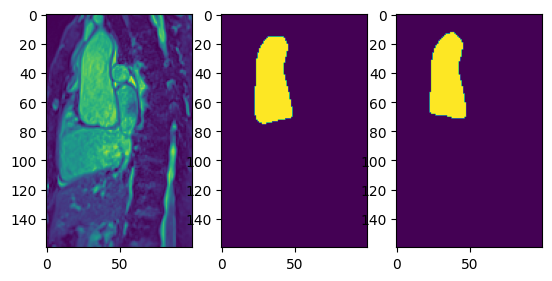

In [19]:
fig, axs = plt.subplots(1,3)

i = 0
axs[0].imshow(X_test[i,...,30,0])
axs[1].imshow(y_test[i,...,30,1])
axs[2].imshow(y_pred[i,...,30,1])


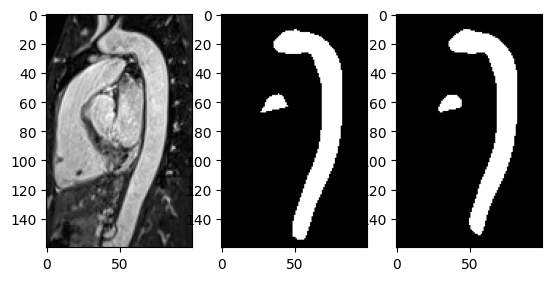

In [21]:
fig, axs = plt.subplots(1,3)

i = 0
axs[0].imshow(X_test[i,...,45,0],cmap='gray')
axs[1].imshow(y_test[i,...,45,1],cmap='gray')
axs[2].imshow(y_pred[i,...,45,1],cmap='gray')

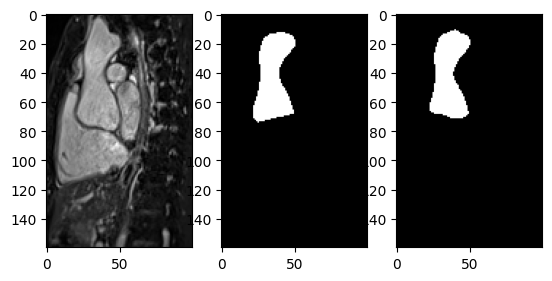

In [22]:
fig, axs = plt.subplots(1,3)

i = 0
axs[0].imshow(X_test[i,...,35,0],cmap='gray')
axs[1].imshow(y_test[i,...,35,1],cmap='gray')
axs[2].imshow(y_pred[i,...,35,1],cmap='gray')